In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Data Cleaning

In [73]:
df_zillow = pd.read_csv('zillow-california.csv')

In [74]:
df_zillow.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [75]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
Date                                     164 non-null object
MedianSoldPrice_AllHomes.California      144 non-null float64
MedianMortageRate                        164 non-null float64
UnemploymentRate                         164 non-null float64
MedianRentalPrice_AllHomes.California    92 non-null float64
dtypes: float64(4), object(1)
memory usage: 6.5+ KB


In [76]:
#Change Date to datetime object, sort by Date, set Date as index
df_zillow['Date'] = pd.to_datetime(df_zillow.Date)
df_zillow = df_zillow.sort_values(by = "Date")
df_zillow = df_zillow.set_index('Date')

In [77]:
df_zillow = df_zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianPrice","MedianRentalPrice_AllHomes.California" : "MedianRentalPrice"})

In [78]:
#Explore missing data
def percent_missing(df, column_name):
    perc_na = sum(df[column_name].isna()) / len(df[column_name])
    return perc_na

In [79]:
for column_name in df_zillow.columns:
    print(column_name, percent_missing(df_zillow, column_name))

MedianPrice 0.12195121951219512
MedianMortageRate 0.0
UnemploymentRate 0.0
MedianRentalPrice 0.43902439024390244


In [80]:
#Both MedianPrice and MedianRentalPrice are numerical column, explore median and mean 
Rental_mean = df_zillow['MedianRentalPrice'].mean()
Rental_median = df_zillow['MedianRentalPrice'].median()
Price_mean = df_zillow['MedianPrice'].mean()
Price_median = df_zillow['MedianPrice'].median()
print("Rental_mean: "+str(Rental_mean)+"\n"
     +"Rental_median: "+str(Rental_median)+"\n"
     +"Price_mean: "+str(Price_mean)+"\n"
     +"Price_median: "+str(Price_median))

Rental_mean: 2128.8315217391305
Rental_median: 2100.0
Price_mean: 382373.55590277765
Price_median: 382467.5


In [81]:
#fill numerical nan value with median
def df_fillna_num_column(df, column_names):
    for column_name in column_names:
        median = float(df[column_name].median())
        print(f"Column Name: {column_name}, Median: {median}")
        df[column_name+"_missing_record"] = [1 if x==True else 0 for x in df[column_name].isna()]
        print(f"Percent Missing: {sum(df[column_name+'_missing_record']) / len(df[column_name+'_missing_record'])}")
        df[column_name] = df[column_name].fillna(median)
        df[column_name] = df[column_name].astype(float)

In [82]:
num_cols = ["MedianRentalPrice", "MedianPrice"]

In [83]:
df_fillna_num_column(df_zillow, num_cols)

Column Name: MedianRentalPrice, Median: 2100.0
Percent Missing: 0.43902439024390244
Column Name: MedianPrice, Median: 382467.5
Percent Missing: 0.12195121951219512


In [84]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2004-01-31 to 2017-08-31
Data columns (total 6 columns):
MedianPrice                         164 non-null float64
MedianMortageRate                   164 non-null float64
UnemploymentRate                    164 non-null float64
MedianRentalPrice                   164 non-null float64
MedianRentalPrice_missing_record    164 non-null int64
MedianPrice_missing_record          164 non-null int64
dtypes: float64(4), int64(2)
memory usage: 9.0 KB


In [85]:
df_zillow.head()

,MedianPrice,MedianMortageRate,UnemploymentRate,MedianRentalPrice,MedianRentalPrice_missing_record,MedianPrice_missing_record
Date,,,,,,
2004-01-31,326752.55,5.02,7.9,2100.0,1,0
2004-02-29,329501.50,4.94,7.8,2100.0,1,0
2004-03-31,340125.45,4.74,7.8,2100.0,1,0
2004-04-30,355329.50,5.16,7.5,2100.0,1,0
2004-05-31,367818.15,5.64,7.3,2100.0,1,0


## Business Question: Can we correctly predict MedianPrice of all california housing 

For our first run of SARIMA on the MedianPrice, d and D for detrending and removing the seasonality was 2 for both cases. The seasonality lag was m=18. Then using auto_arima, the best chosen model based on AIC and BIC which is
SARIMAX(1, 2, 1)x(0, 2, 1, 18). The AIC and BIC scores were AIC=2008.358, BIC=2021.021. The RMSE for this model was 418089.76.

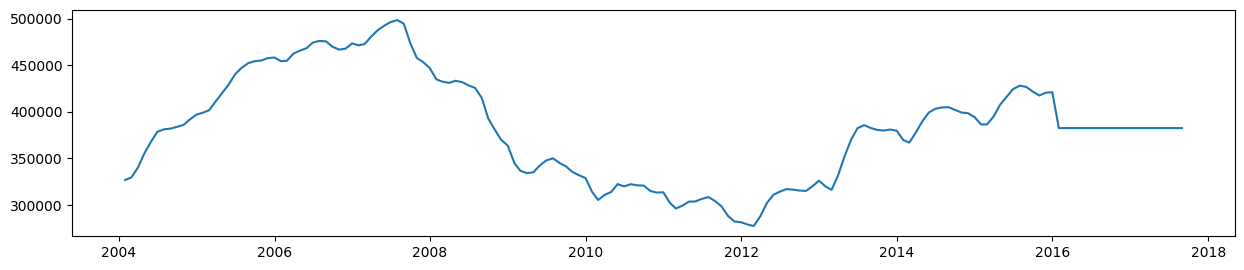

In [86]:
MedianPrice = df_zillow.MedianPrice
plt.figure(figsize=(15,3), dpi=100)
plt.plot(MedianPrice)
plt.show()

In [87]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

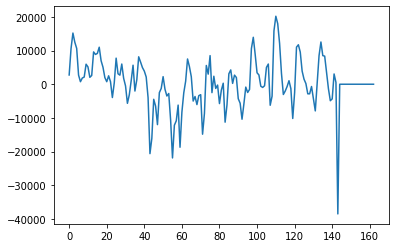

In [88]:
d1 = np.diff(MedianPrice)
plt.plot(d1)
plt.show()

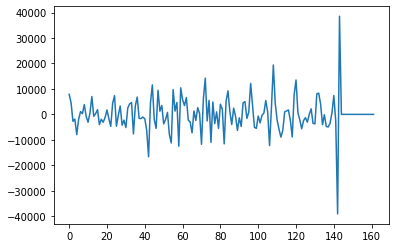

In [89]:
d2 = np.diff(d1)
plt.plot(d2) 
plt.show()

In [90]:
adf_test(d2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.136172
p-value                          0.000012
#Lags Used                      12.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


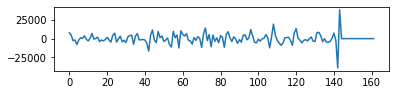

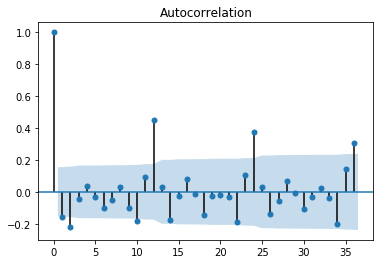

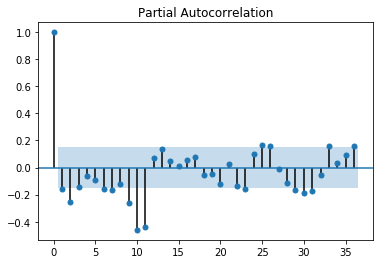

In [91]:
plt.subplot(3,1,1)
plt.plot(d2) 
plt.show()
plot_acf(d2,lags=36) 
plt.show()
plot_pacf(d2,lags=36) 
plt.show()

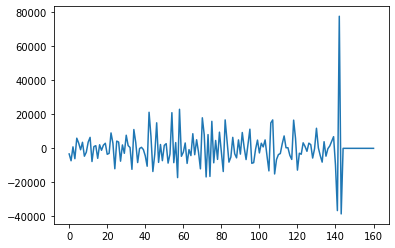

Results of Dickey-Fuller Test:
Test Statistic                -8.035966e+00
p-value                        1.902429e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64


In [92]:
d3 = np.diff(d2)
plt.plot(d3) 
plt.show()
adf_test(d3)

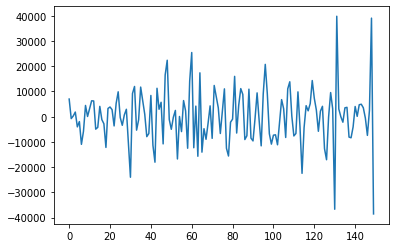

In [93]:
# First time seasonality differencing
d4 = list()
for i in range(12, len(d2)):
    value = d2[i] - d2[i - 18]
    d4.append(value)

plt.plot(d4) 
plt.show()

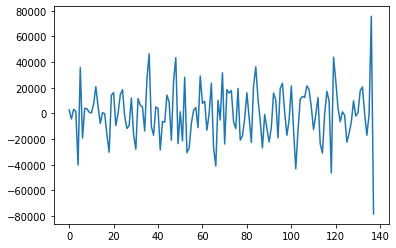

In [94]:
# Second time seasonality differencing
d5 = list()
for i in range(12, len(d4)):
    value = d4[i] - d4[i - 18]
    d5.append(value)

plt.plot(d5) 
plt.show()

In [95]:
#Fit ARIMA model with d = 2 with seasonality m = 12 
#Do train-test split on 80-20 rules
train_size = int(len(MedianPrice) * 0.80)
train, test = MedianPrice[:train_size], MedianPrice[train_size:]
train.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianPrice, dtype: float64

In [111]:
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=18,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 18); AIC=2342.361, BIC=2355.908, Fit time=1.386 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 18); AIC=2353.812, BIC=2359.231, Fit time=0.015 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 18); AIC=2355.507, BIC=2366.345, Fit time=0.349 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 18); AIC=2413.825, BIC=2424.663, Fit time=0.302 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 1, 18); AIC=2339.156, BIC=2355.413, Fit time=1.743 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 0, 18); AIC=2342.479, BIC=2356.026, Fit time=1.391 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 1, 2, 18); AIC=2341.897, BIC=2360.864, Fit time=4.497 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 0, 18); AIC=2340.557, BIC=2351.395, Fit time=0.381 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(2, 1, 2, 18); AIC=2344.221, BIC=2365.898, Fit time=3.973 seconds
Fit ARIMA: order=(0, 2, 1) s

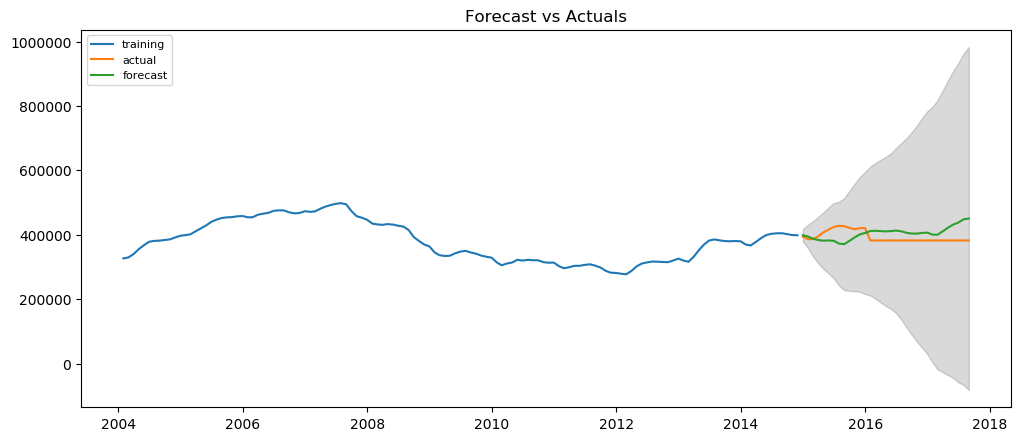

In [112]:
fitted = model.fit(train)
fc, conf = fitted.predict(len(test), return_conf_int=True,alpha=0.05)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

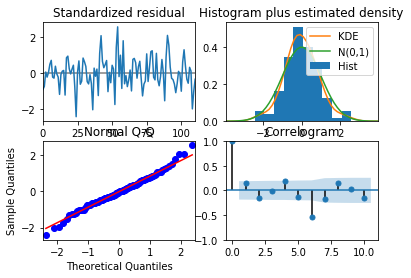

In [113]:
model.plot_diagnostics()
plt.show()

In [114]:
mse = ((fc_series - test) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

34356.35


In [110]:
# creating a table of columns per model
table = fc_series.values
table = table.reshape((-1, 1))

## Exponential Smoothing for Median Price

Using the exponential smoothing, the best model chosen from the RMSE evaluation is additive for trend and additive for seasonality with a RMSE metric scores of 18358. The RMSE for additive trend and multiplcative seasonality was 19220.

In [115]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [116]:
model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12,damped=True)
model2 = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(len(test))
fit2 = model2.fit()
pred2 = fit2.forecast(len(test))

/Users/maxwellcalehuff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/maxwellcalehuff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/maxwellcalehuff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/Users/maxwellcalehuff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


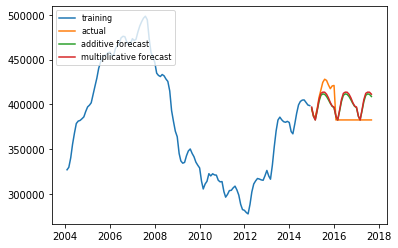

In [117]:
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='additive forecast')
plt.plot(pred2, label='multiplicative forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [118]:
rmse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
rmse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))
print(rmse1)
print(rmse2)

18358.21886218263
19220.753210095212


In [119]:
# concatenating the columns together
table = np.concatenate((table, pred.values.reshape((-1,1))), axis=1)
table = np.concatenate((table, pred2.values.reshape((-1,1))), axis=1)

## SARIMAX on Mortgage Rate

For this model, the additional feature used to help predict Median Price was the Mortage Rate. The trend differencing for d=1 based off inspection and the adf test. The predict plot can be seen down below which contains the train, test, and forecast line. The RMSE for this model is 19150 which is worse off than a univariate case.

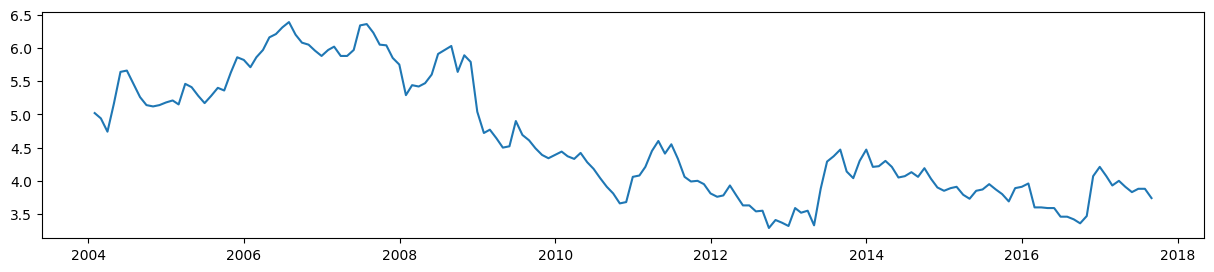

In [155]:
#SARIMAX on Mortgage Rate 
MortgageRate = df_zillow.MedianMortageRate
plt.figure(figsize=(15,3), dpi=100)
pyplot.plot(MortgageRate)
pyplot.show()

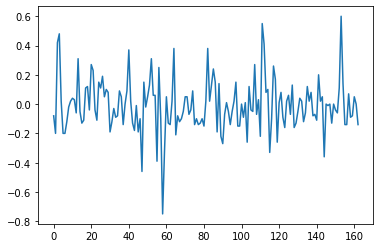

In [179]:
diff = np.diff(MortgageRate)
plt.plot(diff)
plt.show()

In [180]:
adf_test(diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.484764e+00
p-value                        1.268969e-08
#Lags Used                     4.000000e+00
Number of Observations Used    1.580000e+02
Critical Value (1%)           -3.472431e+00
Critical Value (5%)           -2.880013e+00
Critical Value (10%)          -2.576619e+00
dtype: float64


In [181]:
train_size = int(len(MortgageRate) * 0.80)
exog_train = MortgageRate[:train_size, None]
exo_train_idx = MortgageRate[:train_size].index
exog_test = MortgageRate[train_size: ,None]
exo_test_idx = MortgageRate[train_size:].index

In [182]:
#auto selection 
model = pm.auto_arima(train, exogenous=exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, 
                           start_P=0, seasonal=False,
                           d=1,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=2602.913, BIC=2617.251, Fit time=0.120 seconds
Fit ARIMA: order=(0, 1, 0); AIC=2687.275, BIC=2695.877, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=2608.602, BIC=2620.072, Fit time=0.065 seconds
Fit ARIMA: order=(0, 1, 1); AIC=2618.658, BIC=2630.128, Fit time=0.065 seconds
Fit ARIMA: order=(2, 1, 1); AIC=2604.912, BIC=2622.117, Fit time=0.155 seconds
Fit ARIMA: order=(1, 1, 2); AIC=2604.907, BIC=2622.113, Fit time=0.168 seconds
Fit ARIMA: order=(2, 1, 2); AIC=2614.260, BIC=2634.333, Fit time=0.379 seconds
Total fit time: 0.957 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1296.456
Method:                       css-mle   S.D. of innovations           5171.669
Date:                Wed, 11 Dec 2019   AIC                           2602.913
Time:                 

In [183]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [184]:
modelx = SARIMAX(train, order=(1, 1, 1), exog=exog_train)
fitx=modelx.fit()
print(fitx.summary())

                           Statespace Model Results                           
Dep. Variable:            MedianPrice   No. Observations:                  131
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1323.732
Date:                Wed, 11 Dec 2019   AIC                           2655.464
Time:                        15:20:37   BIC                           2666.934
Sample:                    01-31-2004   HQIC                          2660.125
                         - 11-30-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.232e+04   2733.701      4.506      0.000    6960.430    1.77e+04
ar.L1          0.9151      0.058     15.874      0.000       0.802       1.028
ma.L1         -0.8762      0.067    -13.137      0.0

/Users/maxwellcalehuff/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [185]:
final_exog_train = pd.Series(np.squeeze(exog_train), index=exo_train_idx)
final_exog_test = pd.Series(np.squeeze(exog_test), index=exo_test_idx)

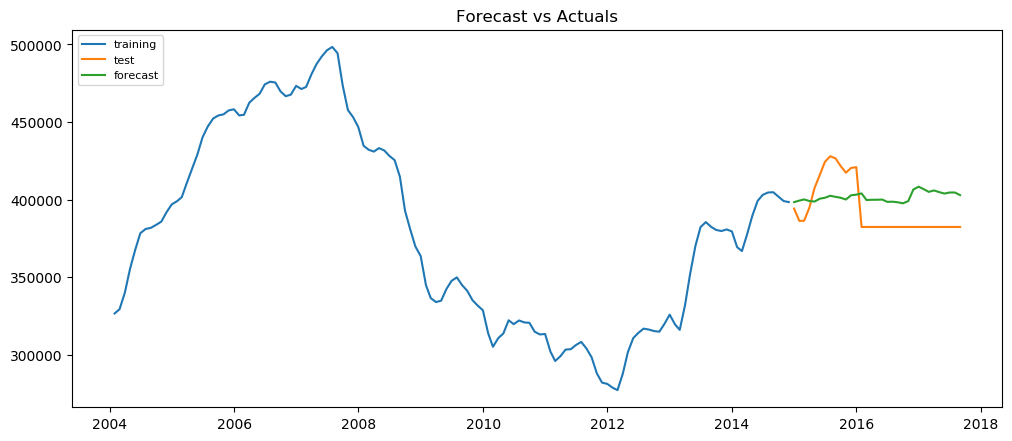

In [186]:
fc = fitx.predict(start=131, end=163, exog=exog_test)
fc_series = pd.Series(fc)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='test')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [187]:
rmse1 = np.sqrt(np.mean(np.square(test.values - fc)))
print(rmse1)

19150.7319194991


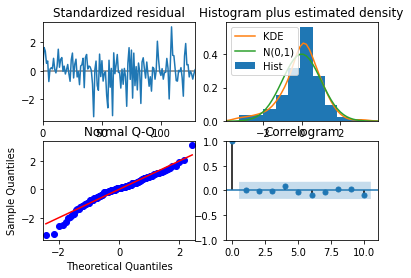

In [188]:
model.plot_diagnostics()
plt.show()

In [189]:
table = np.concatenate((table, fc.values.reshape((-1,1))), axis=1)

## VAR

### Var Median Mortage Rate Model
Using the feautre median mortage rate as an endogenous feature to predict median price, the RMSE was computed to be 22329 with p=2.

### Var Unemployed Rate Model
Using the feature of unemployment rate as an endogenous feature to predict median price, the RMSE was computed to be 17390 with p=3.


### BEST MODEL!! Var Median Rental Price Model
Using the feature of rate as an endogenous feature to predict median price, the RMSE was computed to be 15423 with p=3.

### Var all features Model
This model was really bad so just ignore.

In [70]:
#VAR
df1 = df_zillow[['MedianMortageRate','MedianPrice']]
train = df1[:int(0.80*(len(df1)))]
test = df1[int(0.80*(len(df1))):]
train.head()

,MedianMortageRate,MedianPrice
Date,,
2004-01-31,5.02,326752.55
2004-02-29,4.94,329501.50
2004-03-31,4.74,340125.45
2004-04-30,5.16,355329.50
2004-05-31,5.64,367818.15


In [71]:
model = VAR(endog=train)
model_fit = model.fit(2)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Dec, 2019
Time:                     11:18:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.9991
Nobs:                     129.000    HQIC:                   13.8675
Log likelihood:          -1244.73    FPE:                    962718.
AIC:                      13.7774    Det(Omega_mle):         892214.
--------------------------------------------------------------------
Results for equation MedianMortageRate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.021004         0.098269           -0.214           0.831
L1.MedianMortageRate         1.041507         0.091833           11.341           0.000
L1.MedianPrice      

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [72]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
pred = pd.DataFrame(fc, columns=['MedianMortageRate', 'MedianPrice'])
pred.set_index(test.index, inplace=True)

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


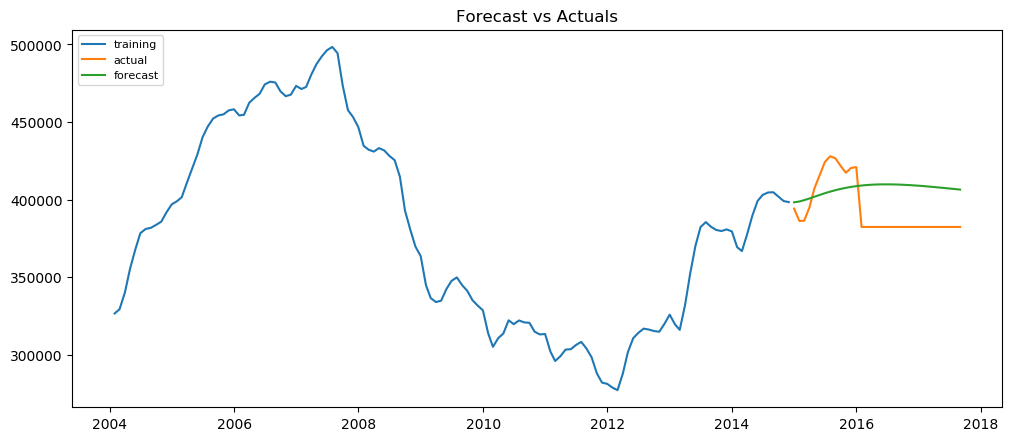

In [73]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianPrice, label='training')
plt.plot(test.MedianPrice, label='actual')
plt.plot(pred['MedianPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [74]:
rmse1 = np.sqrt(np.mean(np.square(test.MedianPrice - pred.MedianPrice)))
print(rmse1)

22329.18569787723


In [79]:
table = np.concatenate((table, pred.MedianPrice.values.reshape((-1,1))), axis=1)

## Vars with Unemployment Rate

Using Vars with Unemployment Rate and selecting p=3, the RMSE for was computed to be 17390. This is the best model so far.

In [87]:
#VAR with unemployment rate
df1 = df_zillow[['UnemploymentRate','MedianPrice']]
train = df1[:int(0.80*(len(df1)))]
test = df1[int(0.80*(len(df1))):]
train.head()

,UnemploymentRate,MedianPrice
Date,,
2004-01-31,7.9,326752.55
2004-02-29,7.8,329501.50
2004-03-31,7.8,340125.45
2004-04-30,7.5,355329.50
2004-05-31,7.3,367818.15


In [88]:
model = VAR(endog=train)
model_fit = model.fit(3)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Dec, 2019
Time:                     11:21:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.1327
Nobs:                     128.000    HQIC:                   15.9475
Log likelihood:          -1361.78    FPE:                7.42943e+06
AIC:                      15.8207    Det(Omega_mle):     6.67895e+06
--------------------------------------------------------------------
Results for equation UnemploymentRate
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       3.967600         0.989520            4.010           0.000
L1.UnemploymentRate         0.640480         0.090069            7.111           0.000
L1.MedianPrice           

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [89]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
pred = pd.DataFrame(fc, columns=['UnemploymentRate', 'MedianPrice'])
pred.set_index(test.index, inplace=True)

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


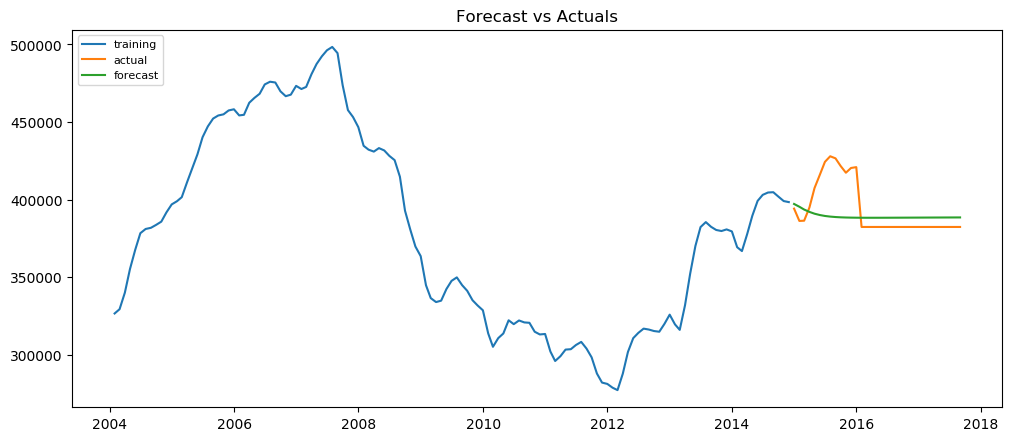

In [90]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianPrice, label='training')
plt.plot(test.MedianPrice, label='actual')
plt.plot(pred['MedianPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [91]:
rmse1 = np.sqrt(np.mean(np.square(test.MedianPrice - pred.MedianPrice)))
print(rmse1)

17390.69455583946


In [92]:
table = np.concatenate((table, pred.MedianPrice.values.reshape((-1,1))), axis=1)

## BEST MODEL!!!! Vars with Median Rental Price
Using vars model with the median rental price with p=3, the RMSE evaluation score was computed to be 15423. This is the best model thus far.

In [94]:
#VAR with median rental rate
df1 = df_zillow[['MedianRentalPrice','MedianPrice']]
train = df1[:int(0.80*(len(df1)))]
test = df1[int(0.80*(len(df1))):]
train.head()

,MedianRentalPrice,MedianPrice
Date,,
2004-01-31,2100.0,326752.55
2004-02-29,2100.0,329501.50
2004-03-31,2100.0,340125.45
2004-04-30,2100.0,355329.50
2004-05-31,2100.0,367818.15


In [95]:
model = VAR(endog=train)
model_fit = model.fit(3)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Dec, 2019
Time:                     11:22:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.5800
Nobs:                     128.000    HQIC:                   25.3948
Log likelihood:          -1966.40    FPE:                9.41577e+10
AIC:                      25.2680    Det(Omega_mle):     8.46464e+10
--------------------------------------------------------------------
Results for equation MedianRentalPrice
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       64.913265        63.664866            1.020           0.308
L1.MedianRentalPrice         0.810301         0.090550            8.949           0.000
L1.MedianPrice      

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [96]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
pred = pd.DataFrame(fc, columns=['MedianRentalPrice', 'MedianPrice'])
pred.set_index(test.index, inplace=True)

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


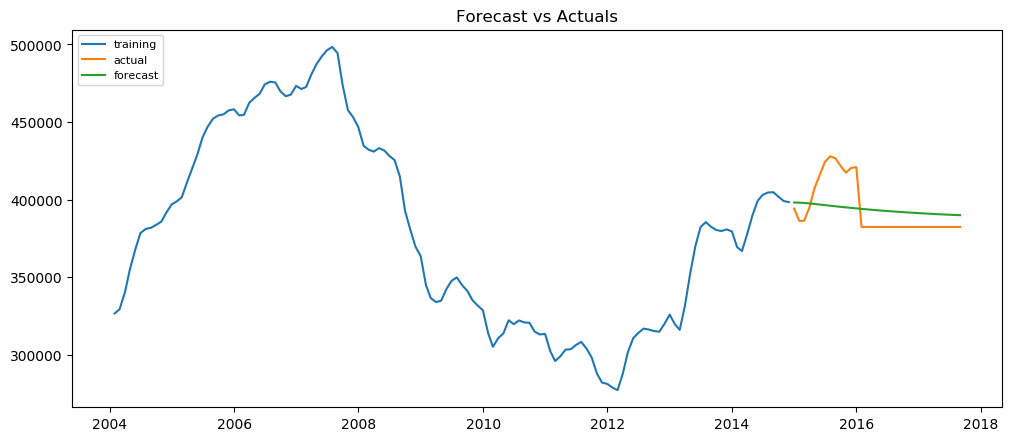

In [97]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianPrice, label='training')
plt.plot(test.MedianPrice, label='actual')
plt.plot(pred['MedianPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [98]:
rmse1 = np.sqrt(np.mean(np.square(test.MedianPrice - pred.MedianPrice)))
print(rmse1)

15423.906710444571


In [99]:
table = np.concatenate((table, pred.MedianPrice.values.reshape((-1,1))), axis=1)

In [102]:
df = pd.DataFrame(table, columns=['ARIMA', 'ETS(add/add)',
                                  'ETS(add/mul)', 'SARIMAX(Mortage Rate)',
                                  'VAR(Mortage Rate)', 'VAR(Unemployed Rate)',
                                  'VAR(Median Rental Price)'])
df = df.set_index(pred.index)

In [108]:
df.to_csv('predictions.csv')

## Vars on Unemployment rate and Median Rental Price
This model is bad.

In [104]:
#VAR with median rental rate
df1 = df_zillow[['UnemploymentRate','MedianRentalPrice','MedianPrice']]
train = df1[:int(0.80*(len(df1)))]
test = df1[int(0.80*(len(df1))):]
train.head()

,UnemploymentRate,MedianRentalPrice,MedianPrice
Date,,,
2004-01-31,7.9,2100.0,326752.55
2004-02-29,7.8,2100.0,329501.50
2004-03-31,7.8,2100.0,340125.45
2004-04-30,7.5,2100.0,355329.50
2004-05-31,7.3,2100.0,367818.15


In [105]:
model = VAR(endog=train)
model_fit = model.fit(3)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     23:28:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    24.5524
Nobs:                     128.000    HQIC:                   24.1555
Log likelihood:          -2043.45    FPE:                2.36094e+10
AIC:                      23.8840    Det(Omega_mle):     1.88399e+10
--------------------------------------------------------------------
Results for equation UnemploymentRate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        4.308374         1.016944            4.237           0.000
L1.UnemploymentRate          0.605508         0.091528            6.616           0.000
L1.MedianRentalPrice 

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [106]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
pred = pd.DataFrame(fc, columns=['UnemploymentRate','MedianRentalPrice','MedianPrice'])
pred.set_index(test.index, inplace=True)

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


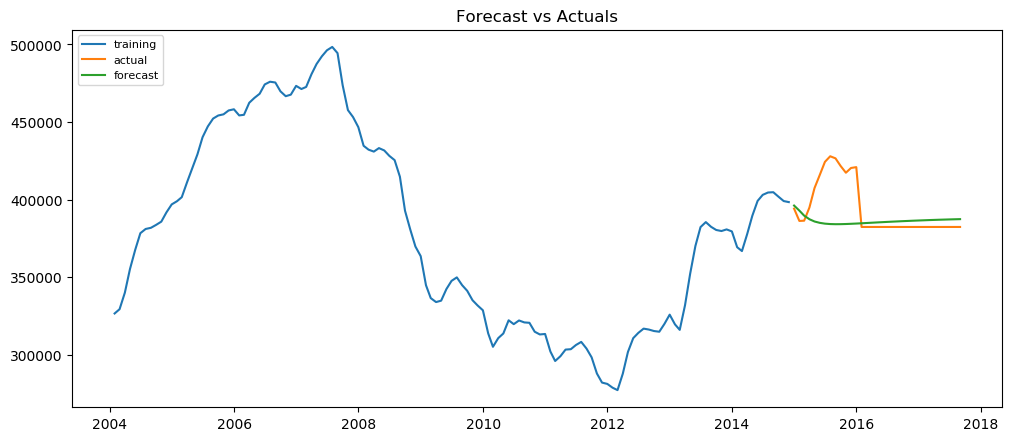

In [107]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianPrice, label='training')
plt.plot(test.MedianPrice, label='actual')
plt.plot(pred['MedianPrice'], label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [108]:
rmse1 = np.sqrt(np.mean(np.square(test.MedianPrice - pred.MedianPrice)))
print(rmse1)

19263.64717731415


## Vars on all features

In [109]:
# VAR on all 
df2 = df_zillow[['MedianMortageRate','MedianPrice','MedianRentalPrice','UnemploymentRate']]
train = df2[:int(0.80*(len(df2)))]
test = df2[int(0.80*(len(df2))):]
train.head()

,MedianMortageRate,MedianPrice,MedianRentalPrice,UnemploymentRate
Date,,,,
2004-01-31,5.02,326752.55,2100.0,7.9
2004-02-29,4.94,329501.50,2100.0,7.8
2004-03-31,4.74,340125.45,2100.0,7.8
2004-04-30,5.16,355329.50,2100.0,7.5
2004-05-31,5.64,367818.15,2100.0,7.3


In [110]:
model = VAR(endog=train)
model_fit = model.fit(1)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 10, Dec, 2019
Time:                     23:28:08
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    21.3454
Nobs:                     130.000    HQIC:                   21.0835
Log likelihood:          -2076.63    FPE:                1.19860e+09
AIC:                      20.9043    Det(Omega_mle):     1.03065e+09
--------------------------------------------------------------------
Results for equation MedianMortageRate
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.267206         0.309395           -0.864           0.388
L1.MedianMortageRate         0.901033         0.037537           24.004           0.000
L1.MedianPrice      

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [111]:
train.head()

,MedianMortageRate,MedianPrice,MedianRentalPrice,UnemploymentRate
Date,,,,
2004-01-31,5.02,326752.55,2100.0,7.9
2004-02-29,4.94,329501.50,2100.0,7.8
2004-03-31,4.74,340125.45,2100.0,7.8
2004-04-30,5.16,355329.50,2100.0,7.5
2004-05-31,5.64,367818.15,2100.0,7.3


In [112]:
train.columns

Index(['MedianMortageRate', 'MedianPrice', 'MedianRentalPrice',
       'UnemploymentRate'],
      dtype='object')

In [113]:
fc = model_fit.forecast(model_fit.y, steps=len(test))
pred = pd.DataFrame(fc, columns=['MedianMortageRate', 'MedianPrice', 'MedianRentalPrice','UnemploymentRate'])
pred.set_index(test.index, inplace=True)

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


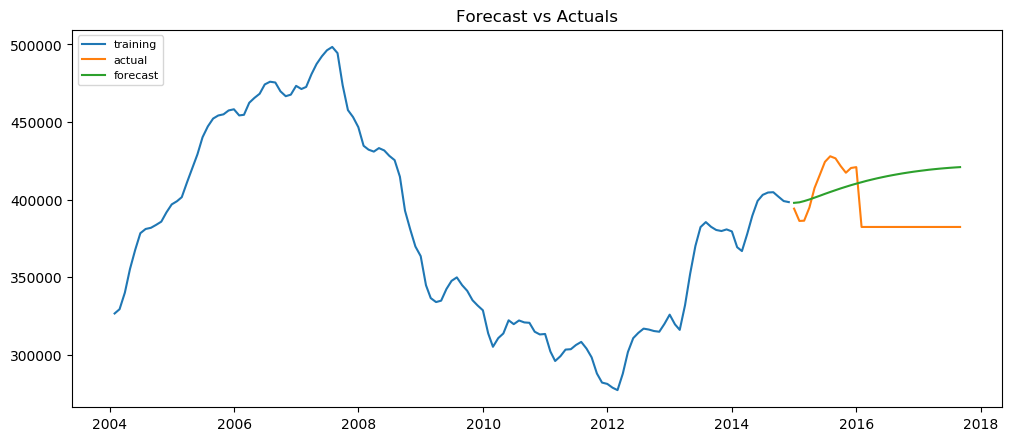

In [114]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.MedianPrice, label='training')
plt.plot(test.MedianPrice, label='actual')
plt.plot(pred.MedianPrice, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [115]:
rmse1 = np.sqrt(np.mean(np.square(test.MedianPrice - pred.MedianPrice)))
print(rmse1)

28470.466655339205
